## Quantum-enhanced Markov chain Monte Carlo


### Problem: Sampling Bolztmann Distribution for Ising model

Given a random Ising model:
$$
E(\bm{s}) = -\sum^{n}_{j>k}J_{jk}s_j s_k -\sum^n_{j=1}h_j s_j
$$
We want to get distribution $\mu(\bm{s})$: ($Z$ is partition function.)
$$
\mu(\bm{s}) = \dfrac{1}{Z}e^{-E(\bm{s})/T}
$$

### Quantum Algorithm

(Step 1) Prepare a random spin configuration $\ket{s}$ as the initial state. For example: If $s=00110$, prepare $\ket{00110}$ as the initial state.

(Step 2) Prepare a Hamiltonian as the ansatz. 
$$H = (1-\gamma)\alpha H_{prob} + \gamma H_{mix},$$ 
with ($\alpha$ is normalization factor) 
$$H_{prob} = -\sum^{n}_{j>k}J_{jk}X_j X_k -\sum^n_{j=1}h_j X_j $$
and
$$
H_{mix} = \sum^n_{j=1}X_J
$$
**For each jump, the parameter $\gamma$ is chosen randomly!**

(Step 3) Prepare the ansatz in the circuit based on the Hamiltonian:
$$
e^{-iH(\gamma)t}
$$
**For each jump, the parameter $t$ is also chosen randomly!**

(Step 4) Measure all the qubits and the outcome corresponds a new state $\ket{s'}$

(Step 5) Calculate the Acceptance rate for the quantum transition $\ket{s}\rightarrow{}\ket{s'}$:
$$
A(s'|s) = {\rm min}(1, e^{-\Delta E/T})
$$

(Step 6) Return to Step 2. Continue until the Markov process conveges.

### Coding
Input library.

In [1]:
from qiskit import QuantumCircuit, BasicAer, QuantumRegister, transpile
from qiskit.quantum_info.operators import Operator
from scipy.linalg import expm
import numpy as np
from matplotlib import pyplot as plt
import itertools

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 



`get_initial_circuit` will return the quantum circuit that initializes the input state.

In [2]:
def get_initial_circuit(initial_state: str):
    n = len(initial_state)

    qr = QuantumRegister(size = len(initial_state), name='qr')
    qc = QuantumCircuit(qr)

    ## initialziation
    for i in range(n):
        if initial_state[i]=="1":
            qc.x(i)
    qc.barrier()

    return qc    

`get_transition_circuit` will return the quantum circuit acting as transition operation. **Here, we only consider the 1-D Ising chains to save computing power.**


In [3]:
def get_transition_circuit(h: list, J: np.array, repeat: int):


    n = len(h)
    t = np.random.uniform(2,20)
    gamma = np.random.uniform(.25, .6)
    dt = t/repeat

    X = np.array([[0, 1],
         [1, 0]])

    Z = np.array([[1,  0],
         [0, -1]])



    ## Calculate alpha#################################
    alpha = 0
    
    def get_square_sum(h):
        sum = 0
        for ele in h:
            sum += ele*ele
        return sum

    alpha = np.sqrt(n)/np.sqrt( get_square_sum(h) + get_square_sum(J))

    ######################################################

    qr = QuantumRegister(size = n, name='qr')
    qc = QuantumCircuit(qr)



    for _ in range(repeat):

        ## First half H1 (single term)
        for i in range(n):
            operator_matrix = expm(-1j*(gamma*dt*X - (1-gamma)*alpha*dt*h[i]*Z ))
            operator = Operator(operator_matrix)

            qc.unitary(operator, i, label="Single Gate-"+str(i))

        ## H2 (interaction term)

        for i in range(n//2):
            theta = -2*J[2*i]*(1-gamma)*alpha*dt
            #qc.rzz(theta, 2*i, 2*i+1)
            qc.cx(2*i,2*i+1)
            qc.rz(theta,2*i+1)
            qc.cx(2*i,2*i+1)

        for i in range((n-1)//2 ):
            theta = -2*J[2*i+1]*(1-gamma)*alpha*dt
            #qc.rzz(theta, 2*i+1, 2*i+2)
            qc.cx(2*i+1,2*i+2)
            qc.rz(theta,2*i+2)
            qc.cx(2*i+1,2*i+2)

        qc.barrier()

    for i in range(n):
        operator_matrix = expm(-1j*(gamma*dt*X - (1-gamma)*alpha*dt*h[i]*Z ))
        operator = Operator(operator_matrix)

        qc.unitary(operator, i, label="Single Gate-"+str(i))

    qc.measure_all()


    return qc

In [4]:
def transition_jump(input_state, circ):

    circ_init = get_initial_circuit(input_state)
    backend = BasicAer.get_backend('qasm_simulator')
    circ_total = circ_init + circ
    job = backend.run(circ_total, shots=1)
    res = job.result()
    new_state = list(res.get_counts(circ_total).keys())[0]

    return new_state


`transition_sampling` returns the sampling of measurement outcome of a given transition circuit.

In [5]:
def transition_sampling(input_state, circ, shots):
    circ_init = get_initial_circuit(input_state)
    backend = BasicAer.get_backend('qasm_simulator')
    circ_total = circ_init + circ
    job = backend.run(circ_total, shots=shots)
    res = job.result()
    counts = res.get_counts(circ_total)


    n = len(input_state)
    counter = np.zeros(2**n)

    for ele in range(2**n):
        result_str = "{0:b}".format(ele).zfill(n)
        if result_str in counts:
            counter[ele] = counts[result_str]
    
    return counter





`get_energy` returns the energy given a state and Hamiltonian coefficient $h$ and $J$

In [6]:
def get_energy(h, J, state):

    n= len(state)
    spin_state=[1 if ele=="0" else -1 for ele in state]
    E = 0

    for i in range(n):
        E+= -h[i]*spin_state[i]
    
    for i in range(n-1):
        E+= -J[i]*spin_state[i]*spin_state[i+1]

    return E


Let's take a look at our transition circuit:

Initial state is : 01011


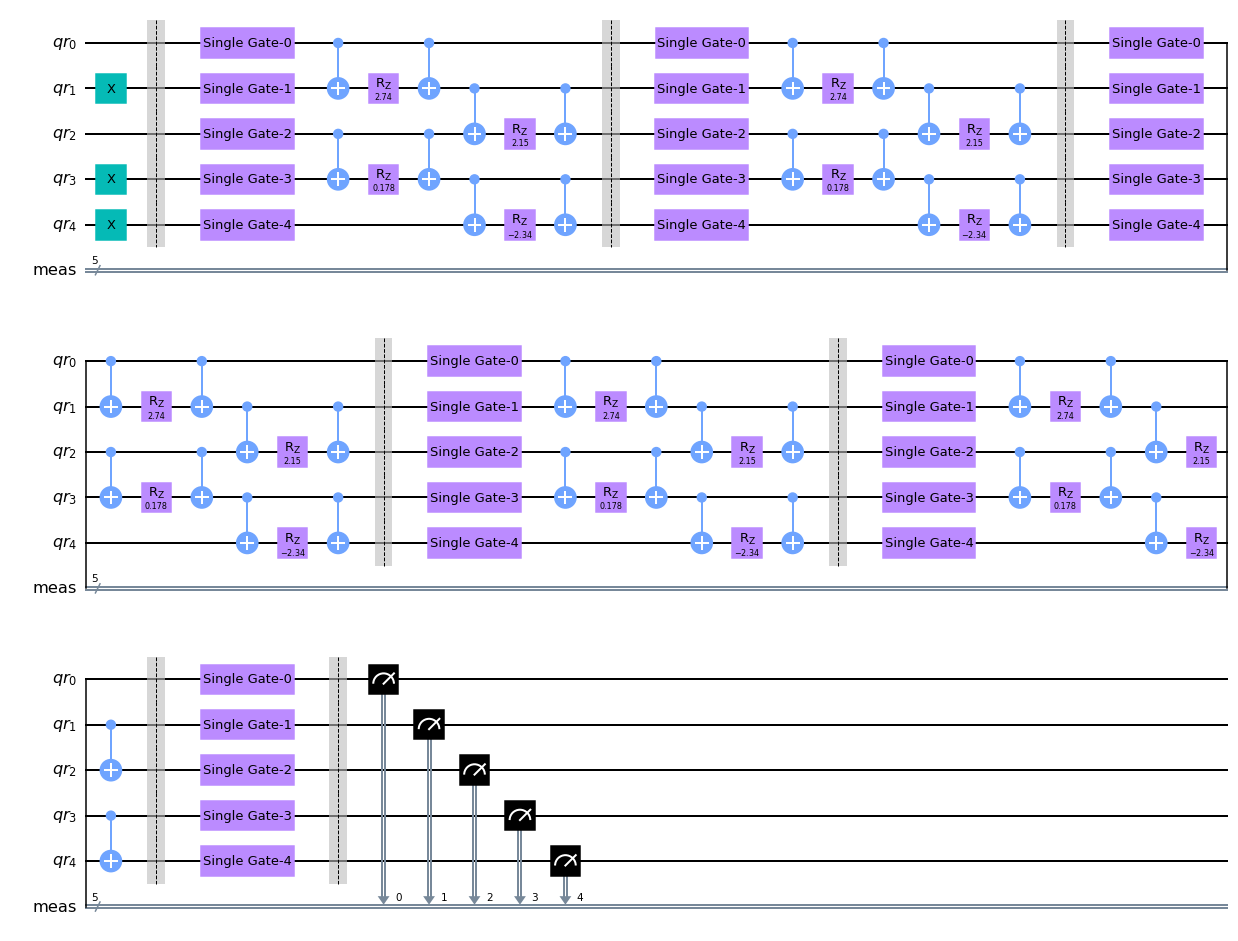

In [7]:
n = 5
initial_state = ''
for _ in range(n):
    initial_state = initial_state + str(np.random.randint(2))

print("Initial state is :",initial_state)

h = np.random.normal(0,1,n)
J = np.random.normal(0,1,n-1)
T = 1
Ntot = 1000
repeat = 5

(get_initial_circuit(initial_state)+get_transition_circuit(h=h,J=J,repeat=repeat)).draw('mpl')

Cool! Seems we reached the same circuit shape as mentioned in the paper. Notice that since `qasm_simulator` cannot accept RZZ gates, here we decomposed the RZZ gates with CNOT gates and RZ gates.

Please ignore the next cell.

In [8]:
n = 5
initial_state = ''
for _ in range(n):
    initial_state = initial_state + str(np.random.randint(2))

print("Initial state is :",initial_state)

h = np.random.normal(0,1,n)
J = np.random.normal(0,1,n-1)
T = 10
Ncirc = 50
Ntot = 100
repeat = 5

Counter = np.zeros(2**n,dtype=np.int32)
Transition_Matrix = np.zeros((2**n,2**n), dtype = np.int32)

state = initial_state
circ_tran = get_transition_circuit(h=h, J=J, repeat=repeat)

for i in range(Ntot):
    new_state = transition_jump(input_state=state, circ=circ_tran)
    E0 = get_energy(h, J, state)
    E1 = get_energy(h, J, new_state)
    A = np.exp(-(E1-E0)/T)
    if np.random.uniform()<A:
        Counter[int(new_state,2)]+=1
        Transition_Matrix[int(state,2)][int(new_state,2)]+=1
        state = new_state


Initial state is : 11000


c:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  """


`get_sampling_matrix` return the full count matrix (C mentioned in Appendix 3b). 

In [8]:
def get_sampling_matrix(circ, n, shots):

    C = np.zeros((2**n, 2**n))
    for ele in range(2**n):
        state = "{0:b}".format(ele).zfill(n)
        count_array = transition_sampling(input_state=state, circ=circ, shots=shots)
        C[ele][:] = count_array

    return C

`get_proposal_matrix` returns the proposal matrix Q of the quantum algorithm mentioned in the main text. 

In [9]:
def get_proposal_matrix(h, J, repeat, shots, Ncirc):
    n = len(h)
    Q=np.zeros((2**n, 2**n))
    C_total = np.zeros((Ncirc, 2**n, 2**n))
    
    for circ_index in range(Ncirc):
        circ = get_transition_circuit(h=h, J=J, repeat=repeat)
        C = get_sampling_matrix(circ=circ, n=n, shots=shots)
        C_total[circ_index][:][:] = C

    C_sum = sum(C_total)
    #print(np.sum(C_sum,axis=1))

    for row, column in itertools.product(range(2**n), range(2**n)):
        Q[row][column] = C_sum[row][column]/sum(C_sum[row])
        #print(sum(C_sum[row]))


    return Q




Let's take a look at the shape of Q!

In [10]:
n = 6
h = np.random.normal(0,1,n)
J = np.random.normal(0,1,n-1)
T = 10
Ncirc = 10
repeat = 10

Q = get_proposal_matrix(h=h, J=J, repeat=repeat, shots=20000, Ncirc=Ncirc)

plt.matshow(Q)
plt.colorbar()
plt.show()

`get_transition_matrix` returns the transition matrix P mentioned in the main text.

In [12]:
def get_transition_matrix(Q, h, J, T):
    n = len(h)
    P = np.zeros((2**n, 2**n))
    Energy_list = np.zeros(2**n)
    for ele in range(2**n):
        state = "{0:b}".format(ele).zfill(n)
        Energy_list[ele] = get_energy(h=h, J=J, state=state)
    
    for row, column in itertools.product(range(2**n), range(2**n)):
        if row!=column:
            Energy_gap = Energy_list[column]-Energy_list[row]
            P[row][column] = Q[row][column]*min(1, np.exp(-Energy_gap/T))

    for ele in range(2**n):
        P[ele][ele]= 1 - sum(P[ele])

    return P

    


Let's take a look at P!

In [13]:
P = get_transition_matrix(Q=Q, h=h, J=J, T=T)

plt.matshow(P)
plt.colorbar()
plt.show()


`get_delta` returns the value delta(spectral gap), given the transition matrix.

In [15]:
def get_delta(P):

    eigenvalue = np.linalg.eigvals(P)
    eigenvalue = np.abs(eigenvalue)
    eigenvalue = -np.sort(-eigenvalue)
    

    delta = 1 - eigenvalue[1]

    return delta

`get_T_delta_curve` returns the plot curve for T-delta relation(quantum).

In [16]:
def get_T_delta_curve(h, J, repeat, shots, Ncirc):

    #T_range = np.append([1e-3, 5e-3, 1e-2],np.logspace(-1,2,num=20))
    #T_range = np.append(T_range, [5e2, 1e3])
    T_range = np.logspace(-3,3)

    delta_list = np.zeros(len(T_range))
    Q = get_proposal_matrix(h=h, J=J, repeat = repeat, shots=shots, Ncirc=Ncirc)

    for i, T_step in enumerate(T_range):
        P = get_transition_matrix(Q=Q, h=h, J=J, T=T_step)
        delta = get_delta(P)
        delta_list[i] = delta




    return T_range, delta_list


    

`get_T_delta_curve_uniform` returns the plot curve for T-delta relation(classical uniform).

In [55]:
def get_T_delta_curve_uniform(h, J):

    def get_uniform_delta(h,J,T):
        n = len(h)
        Q = np.ones((2**n,2**n))/(2**n)
        P = get_transition_matrix(Q=Q, h=h, J=J, T=T)
        delta = get_delta(P)

        return delta

    T_range = np.logspace(-3,3)
    delta_list = np.zeros(len(T_range))

    for i, T_step in enumerate(T_range):
        delta_list[i] = get_uniform_delta(h=h, J=J, T=T_step)

    return T_range, delta_list

In [61]:
n = 6
T = 10
Ncirc = 10
shots = 8192
repeat = 10
N_instance=5
h = np.random.normal(0,1,n)
J = np.random.normal(0,1,n-1)

delta_T_list_total=[]
for _ in range(N_instance):
    T_range, delta_T_list = get_T_delta_curve(h=h, J=J, repeat=repeat, shots=shots, Ncirc=Ncirc)
    delta_T_list_total.append(delta_T_list)

delta_T_list_uniform=[]

for _ in range(N_instance):
    h = np.random.normal(0,1,n)
    J = np.random.normal(0,1,n-1)
    T_range, delta_T_list = get_T_delta_curve_uniform(h=h, J=J)
    delta_T_list_uniform.append(delta_T_list)

    

<ipython-input-12-3e5451b43ad0>:12: RuntimeWarning: overflow encountered in exp
  P[row][column] = Q[row][column]*min(1, np.exp(-Energy_gap/T))


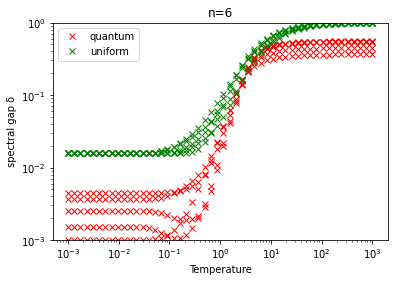

In [62]:
for i in range(N_instance):
    plt.plot(T_range,delta_T_list_total[i],'xr')
    plt.plot(T_range,delta_T_list_uniform[i],'xg')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-3, 1])
plt.title('n='+str(n))
plt.xlabel('Temperature')
plt.ylabel('spectral gap δ')
plt.legend(['quantum','uniform'])

ooopps, Seems like that we get something wrong.... The classical algorithm should be better than the quantum one, which is different from the result presented in the paper.

Let's see the n-delta curve.

In [31]:
def get_n_delta_curve(T, repeat, shots, Ncirc):
    n_range = range(3,10)
    delta_list = np.zeros(len(n_range))

    for i, n_ele in enumerate(n_range):
        h = np.random.normal(0,1,n)
        J = np.random.normal(0,1,n-1)

        Q = get_proposal_matrix(h=h, J=J, repeat=repeat, shots=shots, Ncirc=Ncirc)
        P = get_transition_matrix(Q=Q, h=h, J=J, T=T)
        delta = get_delta(P)
        delta_list[i]=delta

    return n_range, delta_list


In [46]:
n = 5
T = .1
Ncirc = 20
shots = 8192
repeat = 5
N_instance=10

delta_n_list_total=[]
for _ in range(N_instance):
    n_range, delta_n_list = get_n_delta_curve(T=T, repeat=repeat, shots=shots, Ncirc=Ncirc)
    delta_n_list_total.append(delta_n_list)

Text(0, 0.5, 'spectral gap δ')

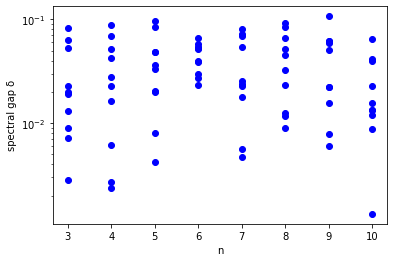

In [51]:
for i in range(N_instance):
    plt.plot(n_range,delta_n_list_total[i],'bo')

plt.yscale('log')
plt.xlabel('n')
plt.ylabel('spectral gap δ')

oooppss, we didn't see the beautiful exponential scaling against n, which is different from the paper's result.